In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random
from scipy.stats import nbinom


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds
D = 40
M = 50
T = 15
period = "M"

start_year = 2018
end_year = 2022
data_split = [0.6, 0.2, 0.2]
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

def compute_pica(y_true, y_pred, alpha=0.05):

    lower = np.quantile(y_pred, alpha / 2, axis=1)
    upper = np.quantile(y_pred, 1 - alpha / 2, axis=1)
    within_interval = (y_true >= lower) & (y_true <= upper)
    empirical_coverage = np.mean(within_interval)
    expected_coverage = 1 - alpha
    return np.abs(empirical_coverage - expected_coverage)



In [2]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)

# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [3]:
class NowcastPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y

set_seed(seed)
train_pnn_dataset = NowcastPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = NowcastPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = NowcastPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [4]:
nowcast_pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
nowcast_pnn_train = BaseTrain("NowcastPNN")
nowcast_pnn_train.train_model(nowcast_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 9.31e+04 - Val loss: 1.22e+06 - ES count: 0
Epoch 2 - Train loss: 7.42e+04 - Val loss: 8.59e+05 - ES count: 0
Epoch 3 - Train loss: 7.27e+04 - Val loss: 8.06e+05 - ES count: 0
Epoch 4 - Train loss: 6.69e+04 - Val loss: 7.75e+05 - ES count: 0
Epoch 5 - Train loss: 6.29e+04 - Val loss: 6.75e+05 - ES count: 0
Epoch 6 - Train loss: 6.05e+04 - Val loss: 6.94e+05 - ES count: 1
Epoch 7 - Train loss: 5.79e+04 - Val loss: 5.9e+05 - ES count: 0
Epoch 8 - Train loss: 5.46e+04 - Val loss: 5.28e+05 - ES count: 0
Epoch 9 - Train loss: 5.18e+04 - Val loss: 5.71e+05 - ES count: 1
Epoch 10 - Train loss: 5.03e+04 - Val loss: 5.18e+05 - ES count: 0
Epoch 11 - Train loss: 4.67e+04 - Val loss: 4.09e+05 - ES count: 0
Epoch 12 - Train loss: 4.49e+04 - Val loss: 5.7e+05 - ES count: 1
Epoch 13 - Train loss: 4.17e+04 - Val loss: 3.52e+05 - ES count: 0
Epoch 14 - Train loss: 3.89e+04 - Val loss: 3.14e+05 - ES count: 0
Epoch 15 - Train loss: 3.66e+04 - Val loss: 3.03e+05 - ES count: 0
Epoch 

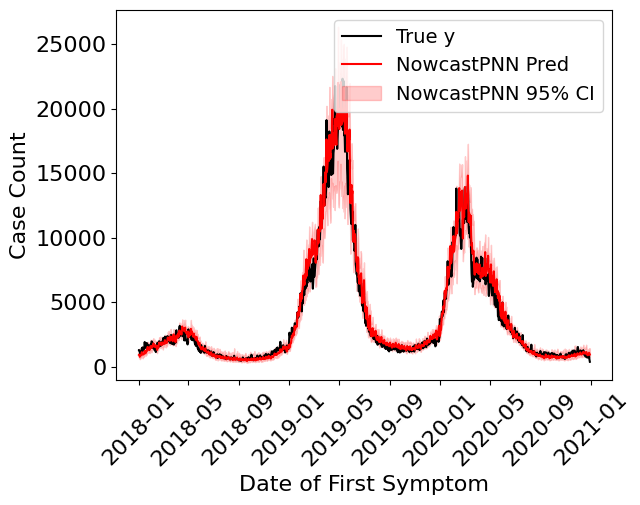

CRPS: 300.3681205479452


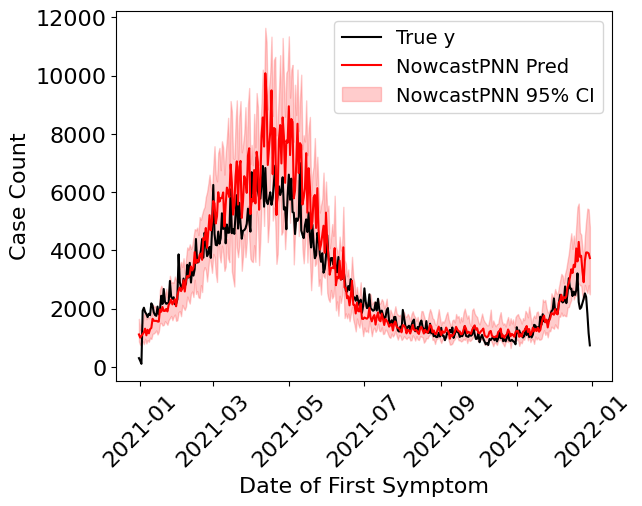

CRPS: 409.64749808219165


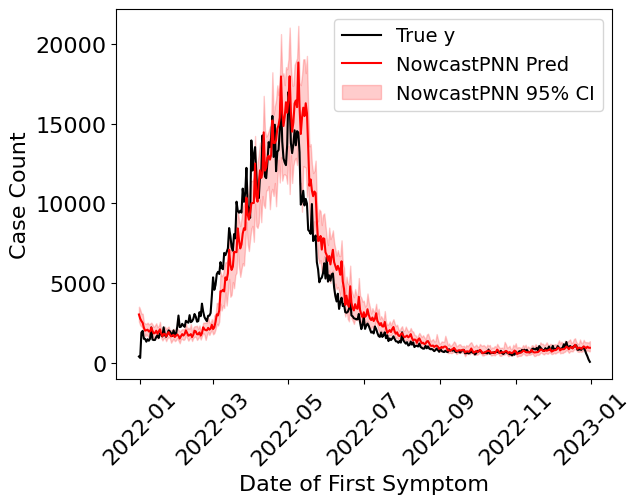

CRPS: 640.6958863387979
PICA: 0.7790334139568216


In [ ]:
nowcast_pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
nowcast_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-NowcastPNN"))

nowcast_pnn_train_samples, train_y_true = eval_pnn(train_pnn_dataset, nowcast_pnn_model)
plot_pnn_preds(nowcast_pnn_train_samples,train_pnn_dataset)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), nowcast_pnn_train_samples).mean()}")

pnn_val_samples, val_y_true = eval_pnn(val_pnn_dataset, nowcast_pnn_model)
plot_pnn_preds(pnn_val_samples,val_pnn_dataset)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), pnn_val_samples).mean()}")

pnn_test_samples, test_y_true = eval_pnn(test_pnn_dataset, nowcast_pnn_model)
plot_pnn_preds(pnn_test_samples,test_pnn_dataset, project_dir/"src"/"outputs"/"visuals"/"same-day-nowcasts"/"NowcastPNN.png")
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), pnn_test_samples).mean()}")
print(f"PICA: {compute_pica(np.array(test_y_true), pnn_test_samples)}")